In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from photo_sketch_dataset import PhotoSketchDataset

/userHome/userhome1/sojeong/miniconda3/envs/psc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fill in correct path below
csv_path = "test_pairs_ps.csv"
data_path = "./Sketchy"  # path to the Sketchy dataset

dataset = PhotoSketchDataset(csv_path, data_path, mode="test")

In [3]:
# pick a class below
category = "raccoon"
category_names=['airplane', 'alarm', 'ant','ape', 'apple', 'armor', 'axe', 'banana', 'bat', 'bear', 'bee', 'beetle', 'bell', 'bench', 
                'bicycle', 'blimp', 'bread', 'butterfly', 'cabin', 'camel','candle', 'cannon', 'car','castle', 'cat', 'chair', 'chicken', 
                'church', 'couch', 'cow', 'crab', 'crocodilian', 'cup', 'deer', 'dog', 'dolphin', 'door', 'duck', 'elephant', 'eyeglasses', 
                'fan', 'fish', 'flower', 'frog', 'geyser', 'giraffe', 'guitar', 'hamburger', 'hammer', 'harp', 'hat', 'hedgehog', 'helicopter', 
                'hermit', 'horse', 'hot-air', 'hotdog', 'hourglass', 'jack-o-lantern', 'jellyfish', 'kangaroo', 'knife', 'lion', 'lizard', 
                'lobster', 'motorcycle', 'mouse', 'mushroom', 'owl', 'parrot', 'pear', 'penguin', 'piano', 'pickup', 'pig', 'pineapple', 
                'pistol', 'pizza', 'pretzel', 'rabbit', 'raccoon', 'racket', 'ray', 'rhinoceros', 'rifle', 'rocket', 'sailboat', 'saw', 
                'saxophone', 'scissors', 'scorpion', 'sea', 'seagull', 'seal', 'shark', 'sheep', 'shoe', 'skyscraper', 'snail', 'snake', 
                'songbird', 'spider', 'spoon', 'squirrel', 'starfish', 'strawberry', 'swan', 'sword', 'table', 'tank', 'teapot', 'teddy', 
                'tiger', 'tree', 'trumpet', 'turtle', 'umbrella', 'violin', 'volcano', 'wading', 'wheelchair', 'windmill', 'window', 'wine', 
                'zebra']

category_idx = category_names.index(category)

80


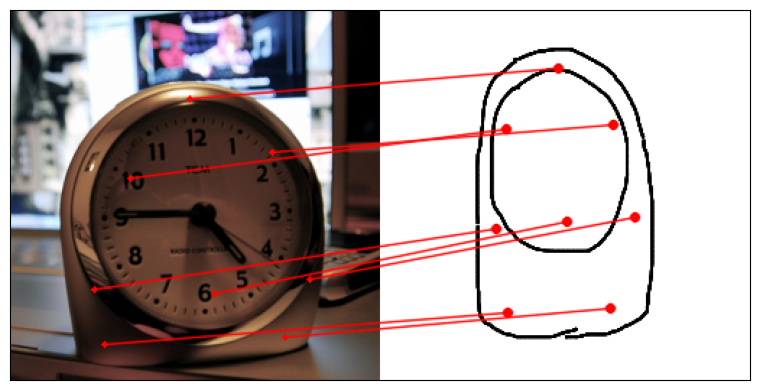

In [4]:
num_photo_per_category = 1
start_idx = category_idx * num_photo_per_category

step_size = 1

for i in range(start_idx, start_idx + num_photo_per_category, step_size):
    print(i)
    # load sample
    data = dataset[i]
    photo, sketch, photo_kps, sketch_kps = data
    photo = photo.unsqueeze(0)
    sketch = sketch.unsqueeze(0)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    # unnormalize the normalized image
    unnorm_photo = photo.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_sketch = sketch.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_photo = unnorm_photo.permute(0, 3, 1, 2)
    unnorm_sketch = unnorm_sketch.permute(0, 3, 1, 2)

    # create canvas
    canvas = np.zeros((256, 256 * 2, 3), dtype=np.uint8)
    canvas[:, :256] = unnorm_photo.cpu()[0].permute(1, 2, 0).numpy() * 255
    canvas[:, 256:] = unnorm_sketch.cpu()[0].permute(1, 2, 0).numpy() * 255

    # extract keypoints
    xa = photo_kps[:, 1]
    ya = photo_kps[:, 0]

    xb = sketch_kps[:, 1]
    yb = sketch_kps[:, 0]

    xa = [int(round(float(x))) for x in xa]
    xb = [int(round(float(x))) for x in xb]
    ya = [int(round(float(x))) for x in ya]
    yb = [int(round(float(x))) for x in yb]

    # draw keypoint annotations
    for j in range(8):
        canvas = cv2.line(canvas, (xa[j], ya[j]), (xb[j] + 256, yb[j]), color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        canvas = cv2.circle(canvas, (xa[j], ya[j]), radius=2, color=(255, 0, 0), thickness=-1)
        canvas = cv2.circle(canvas, (xb[j] + 256, yb[j]), radius=3, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)

    ax.imshow(canvas)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [8]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def warp_image(image, flow):
    h, w = flow.shape[:2]
    flow_map = np.column_stack((flow[..., 0].flat, flow[..., 1].flat))
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    new_coords = coords + flow_map
    new_coords = new_coords.reshape(h, w, 2)
    warp_image = cv2.remap(image, new_coords[..., 0].astype(np.float32), new_coords[..., 1].astype(np.float32), cv2.INTER_LINEAR)
    return warp_image

def visualize_warp(photo, sketch, photo_kps, sketch_kps, dist, save_path=None):
    # 이미지와 키포인트 준비
    photo = photo.unsqueeze(0)
    sketch = sketch.unsqueeze(0)

    print(photo.shape)
    print(sketch.shape)
    
    unnorm_photo = photo.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_sketch = sketch.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_photo = unnorm_photo.permute(0, 3, 1, 2)
    unnorm_sketch = unnorm_sketch.permute(0, 3, 1, 2)

    photo_np = unnorm_photo.cpu()[0].permute(1, 2, 0).numpy() * 255
    sketch_np = unnorm_sketch.cpu()[0].permute(1, 2, 0).numpy() * 255

    xa = photo_kps[:, 1]
    ya = photo_kps[:, 0]
    xb = sketch_kps[:, 1]
    yb = sketch_kps[:, 0]

    xa = [int(round(float(x))) for x in xa]
    xb = [int(round(float(x))) for x in xb]
    ya = [int(round(float(x))) for x in ya]
    yb = [int(round(float(x))) for x in yb]

    # 이미지 워핑
    flow = np.zeros((256, 256, 2))
    for j in range(len(xa)):
        flow[ya[j], xa[j], 0] = xb[j] - xa[j]
        flow[ya[j], xa[j], 1] = yb[j] - ya[j]

    # warped_photo = warp_image(photo_np.astype(np.float32), flow)

    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    canvas = np.zeros((256, 256 * 2, 3), dtype=np.uint8)
    canvas[:, :256] = photo_np.astype(np.uint8)
    canvas[:, 256:] = sketch_np.astype(np.uint8)

    for j in range(len(xa)):
        canvas = cv2.line(canvas, (xa[j], ya[j]), (xb[j] + 256, yb[j]), color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        canvas = cv2.circle(canvas, (xa[j], ya[j]), radius=2, color=(255, 0, 0), thickness=-1)
        canvas = cv2.circle(canvas, (xb[j] + 256, yb[j]), radius=3, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)

    ax.imshow(canvas)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [15]:
for i in (photo, sketch, photo_kps, sketch_kps):
    print(i.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
(8, 2)
(8, 2)


80
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


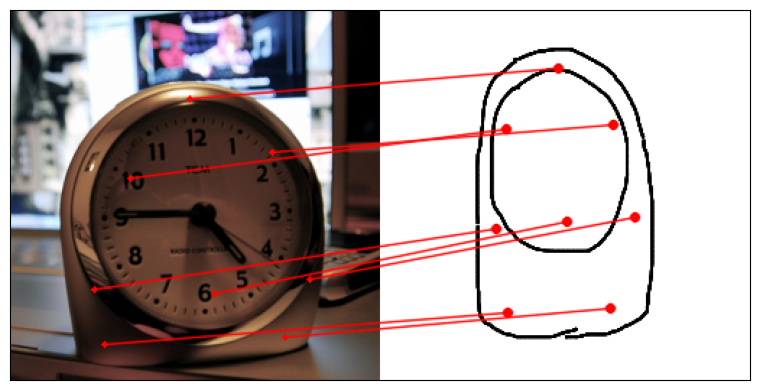

In [16]:
# 예제 데이터셋 준비
# category_idx = 0  # 카테고리 인덱스 설정
# num_photo_per_category = 50
# start_idx = category_idx * num_photo_per_category
# step_size = 5

for i in range(start_idx, start_idx + num_photo_per_category, step_size):
    print(i)
    # 샘플 불러오기
    data = dataset[i]
    photo, sketch, photo_kps, sketch_kps = data
    #print(photo, sketch, photo_kps, sketch_kps)

    # dist 불러오기
    dist = None  # dist 데이터 로드 방법에 맞게 수정 필요

    # 워핑 및 시각화
    visualize_warp(photo, sketch, photo_kps, sketch_kps, dist, save_path=f'warped_image_{i}.png')


80


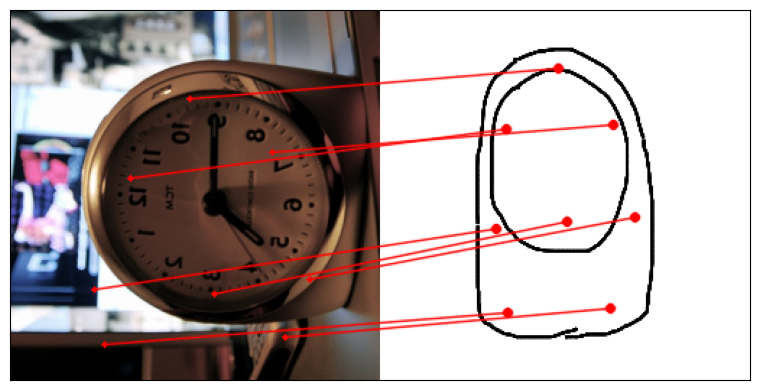

In [7]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

def warp_image(image, flow):
    h, w = flow.shape[:2]
    flow_map = np.column_stack((flow[..., 0].flat, flow[..., 1].flat))
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    new_coords = coords + flow_map
    new_coords = new_coords.reshape(h, w, 2)
    warp_image = cv2.remap(image, new_coords[..., 0].astype(np.float32), new_coords[..., 1].astype(np.float32), cv2.INTER_LINEAR)
    return warp_image

def visualize_warp(photo, sketch, photo_kps, sketch_kps, save_path=None):
    # 이미지와 키포인트 준비
    unnorm_photo = photo.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_sketch = sketch.permute(0, 2, 3, 1) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    unnorm_photo = unnorm_photo.permute(0, 3, 1, 2)
    unnorm_sketch = unnorm_sketch.permute(0, 3, 1, 2)

    photo_np = unnorm_photo.cpu()[0].permute(1, 2, 0).numpy() * 255
    sketch_np = unnorm_sketch.cpu()[0].permute(1, 2, 0).numpy() * 255

    xa = photo_kps[:, 1]
    ya = photo_kps[:, 0]
    xb = sketch_kps[:, 1]
    yb = sketch_kps[:, 0]

    xa = [int(round(float(x))) for x in xa]
    xb = [int(round(float(x))) for x in xb]
    ya = [int(round(float(x))) for x in ya]
    yb = [int(round(float(x))) for x in yb]

    # 이미지 워핑
    flow = np.zeros((256, 256, 2))
    for j in range(len(xa)):
        flow[ya[j], xa[j], 0] = xb[j] - xa[j]
        flow[ya[j], xa[j], 1] = yb[j] - ya[j]

    warped_photo = warp_image(photo_np.astype(np.float32), flow)

    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    canvas = np.zeros((256, 256 * 2, 3), dtype=np.uint8)
    canvas[:, :256] = warped_photo.astype(np.uint8)  # 워핑된 이미지로 변경
    canvas[:, 256:] = sketch_np.astype(np.uint8)

    for j in range(len(xa)):
        canvas = cv2.line(canvas, (xa[j], ya[j]), (xb[j] + 256, yb[j]), color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        canvas = cv2.circle(canvas, (xa[j], ya[j]), radius=2, color=(255, 0, 0), thickness=-1)
        canvas = cv2.circle(canvas, (xb[j] + 256, yb[j]), radius=3, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)

    ax.imshow(canvas)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

# 예제 데이터셋 준비
# category_idx = 0  # 카테고리 인덱스 설정
# num_photo_per_category = 50
# start_idx = category_idx * num_photo_per_category
# step_size = 5

for i in range(start_idx, start_idx + num_photo_per_category, step_size):
    print(i)
    # 샘플 불러오기
    data = dataset[i]
    photo, sketch, photo_kps, sketch_kps = data
    photo = photo.unsqueeze(0)
    sketch = sketch.unsqueeze(0)

    # 워핑 및 시각화
    visualize_warp(photo, sketch, photo_kps, sketch_kps, save_path=f'warped_image_{i}.png')
